## Imports

In [21]:
import torch
from torch.utils.data import DataLoader, Dataset

from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

import cv2
import glob
import os

from datetime import datetime

## Data Loader

In [22]:
class Dataset(Dataset):
    
    def __init__(self, device, train=True):
        self.device = device
        all_data = np.load('data.npz')['X']
        index = int(all_data.shape[0] * 0.85)
        
        np.random.seed(66)
        np.random.shuffle(all_data)
        if train:
            self.data = all_data[:index]
        else:
            self.data = all_data[index:]
            
    def __len__(self):
        'Denotes the total number of samples'
        return self.data.shape[0]
    
    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        img = self.data[index]
        transform = transforms.Compose([transforms.ToTensor()])
        
        return transform(img)

## VAE Definition

In [23]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [24]:
class UnFlatten(nn.Module):
    def forward(self, input, size=128*7*7):
        return input.view(input.size(0), size, 1, 1)

In [25]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6272, z_dim=256):

        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=6, stride=2),
            nn.ReLU(),       
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim).to("cuda")
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):      
        std = logvar.mul(0.5).exp_()
        esp = torch.randn_like(mu)     
        z = (mu + std * esp).to("cuda")
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [26]:
class ModelTraining():
    
    def __init__(self, model, epochs, train_loader, test_loader, device, load_model=None, log_interval = 100):
        if load_model:
            self.folder=load_model
            folder_path = 'saved_models/' + self.folder
            filename = os.listdir(folder_path)[-1]
            print(filename)
            checkpoint = torch.load(folder_path+filename)
            vae.load_state_dict(checkpoint['model_state_dict'])
            self.first_epoch = checkpoint['epoch']
        else:
            dt = datetime.today()
            self.folder = str(dt.hour) + "-" + str(dt.day) + "-" + str(dt.month) + '/'
            self.make_folder()
            self.first_epoch = 1
            
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        

        
        
        self.final_epoch = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        self.batch_size = batch_size
        self.log_interval = log_interval
        
        self.writer = SummaryWriter()
        images = next(iter(self.train_loader)).to(self.device)

        grid = make_grid(images)
        self.writer.add_image('images', grid, 0)
        self.writer.add_graph(self.model, images)
        
    def make_folder(self):
        if os.path.isdir('results/' + self.folder):
            print('Folders already created')
        else:
            os.mkdir('results/' + self.folder)
            os.mkdir('saved_models/' + self.folder)
        
    @staticmethod
    def loss_fn(recon_x, x, mu, logvar, beta=1000):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + beta*KLD, BCE, KLD

    def train(self, epoch):
        self.model.train()
        total_train_loss = 0
        total_bce_loss = 0
        total_kld_loss = 0
        
        for batch_idx, data in enumerate(self.train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            total_loss, bce_loss, kld_loss = self.loss_fn(recon_batch, data, mu, logvar)
            total_loss.backward()
            total_train_loss += total_loss.item()
            total_bce_loss += bce_loss.item()
            total_kld_loss += kld_loss.item() 
            
            self.optimizer.step()
            if batch_idx % self.log_interval == 0:
                
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader),
                    total_loss.item() / len(data)))
        
        
        
        total_train_loss /= len(self.train_loader.dataset)
        total_bce_loss /= len(self.train_loader.dataset)
        total_kld_loss /= len(self.train_loader.dataset)
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, total_train_loss))
        
        self.writer.add_scalar('Train/Average Loss ', total_train_loss, epoch)
        self.writer.add_scalar('Train/BCE Loss ', total_bce_loss, epoch)
        self.writer.add_scalar('Train/KLD Loss ', total_kld_loss, epoch)

    
    def test(self, epoch):
        self.model.eval()
        total_test_loss = 0
        total_bce_loss = 0
        total_kld_loss = 0
        
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                data = data.to(self.device)
                recon_batch, mu, logvar = self.model(data)
                total_loss, bce_loss, kld_loss = self.loss_fn(recon_batch, data, mu, logvar)
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],recon_batch.view(batch_size, 3, 84, 84)[:n]])
                    save_image(comparison.cpu(),
                             'results/' + self.folder + 'reconstruction_' + str(epoch) + '.png', nrow=n)
                
                total_test_loss += total_loss.item()
                total_bce_loss += bce_loss.item()
                total_kld_loss += kld_loss.item() 

        total_test_loss /= len(self.test_loader.dataset)
        total_bce_loss /= len(self.test_loader.dataset)
        total_kld_loss /= len(self.test_loader.dataset)
        
        print('====> Test set loss: {:.4f}'.format(total_test_loss))
                               
        self.writer.add_scalar('Test/Average Loss', total_test_loss, epoch)
        self.writer.add_scalar('Test/BCE Loss ', total_bce_loss, epoch)
        self.writer.add_scalar('Test/KLD Loss ', total_kld_loss, epoch)
                               
    def process(self, save_interval=10):
        for epoch in range(self.first_epoch + 1, self.final_epoch + 1):
            self.train(epoch)
            self.test(epoch)
            with torch.no_grad():
                sample = torch.randn(16, 256).to(self.device)
                sample = self.model.decode(sample).cpu()
                save_image(sample.view(16, 3, 84, 84),
                           'results/' + self.folder + 'sample_' + str(epoch) + '.png')
            
            if epoch != 0 and epoch % save_interval == 0: 
                model_path = "saved_models/" + self.folder + "saved_vae_epoch_" + str(epoch) + ".pt"
                torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()          
            }, model_path)
            

## Training Function

## Parameters

In [27]:
batch_size = 32
epochs = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(Dataset(device), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Dataset(device, train=False), batch_size=batch_size, shuffle=True)

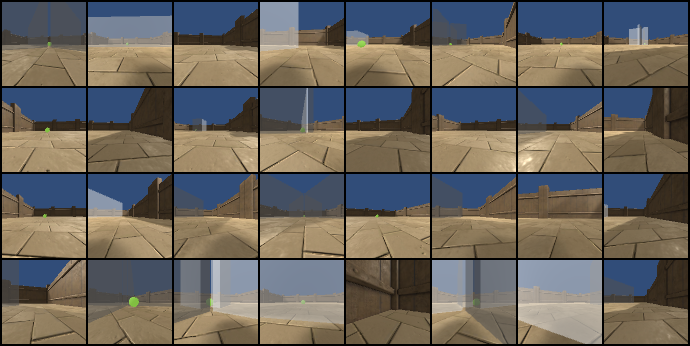

In [28]:
fixed_x= next(iter(train_loader))
save_image(fixed_x, 'real_image.png')
Image('real_image.png')

## Training

In [ ]:
vae = VAE().to(device)
model_date = "13-31-7/" 
ModelTraining(vae, epochs, train_loader, test_loader, device, load_model=model_date).process(save_interval=10)

/media/home/auguste/virtual_environment/animalai/lib/python3.6/site-packages/torch/jit/__init__.py:1007: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%esp : Float(32, 256) = aten::randn_like(%mu, %118, %119, %120, %121), scope: VAE # <ipython-input-5-133183fa8d11>:33:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
/media/home/auguste/virtual_environment/animalai/lib/python3.6/site-packages/torch/jit/__init__.py:1007: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[3, 0, 81, 63] (0.46698465943336487 vs. 0.423840194940567) and 659029 other locations (97.00%)
  check_tolerance, _force_outplace, True, _module_class)
/media/home/auguste/virtual_environment/animalai/lib/python3.6/site

Train Epoch: 21 [0/22037 (0%)]	Loss: 13293.841797
Train Epoch: 21 [3200/22037 (15%)]	Loss: 13452.290039
Train Epoch: 21 [6400/22037 (29%)]	Loss: 13442.180664
Train Epoch: 21 [9600/22037 (44%)]	Loss: 13343.080078
Train Epoch: 21 [12800/22037 (58%)]	Loss: 13371.368164
Train Epoch: 21 [16000/22037 (73%)]	Loss: 13374.728516
Train Epoch: 21 [19200/22037 (87%)]	Loss: 13324.186523
====> Epoch: 21 Average loss: 13318.3736
====> Test set loss: 13307.0876
Train Epoch: 22 [0/22037 (0%)]	Loss: 13343.352539
Train Epoch: 22 [3200/22037 (15%)]	Loss: 13437.945312
Train Epoch: 22 [6400/22037 (29%)]	Loss: 13469.972656
Train Epoch: 22 [9600/22037 (44%)]	Loss: 13285.535156
Train Epoch: 22 [12800/22037 (58%)]	Loss: 13209.210938
Train Epoch: 22 [16000/22037 (73%)]	Loss: 13394.810547


# Assessment

## Load Graph

In [29]:
model_date = "13-31-7/" 

In [30]:
vae = VAE()
path = 'saved_models/' + model_date + 'saved_vae_epoch_200.pt'
checkpoint = torch.load(path)
vae.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: CUDA out of memory. Tried to allocate 152.00 MiB (GPU 0; 5.93 GiB total capacity; 218.41 MiB already allocated; 29.19 MiB free; 15.59 MiB cached)

## Compute Mean Vector

In [ ]:
z_mean = np.zeros(32)
for i, data in enumerate(all_data):
    if i%1e3 == 0:
        print(str(i))
    
    tensor = t(data).view(1, 3, 84, 84)
    with torch.no_grad():
        z_mean += vae.encode(tensor)[0][0].cpu().numpy()
    
np.savez('z_mean.npz', z=z_mean)

## Create Interpolation Video

### Tensor2Image2Video

In [260]:
def interpolation_tensor(model, index, scale=0.5, nb_points=100):
    z_mean = torch.tensor(np.load('z_mean.npz')['z'], dtype=torch.float32).view(1,32)
    folder = 'interpolations/index_' + str(index) + '/'
    os.makedirs(folder)
    for i in range(nb_points+1):
        a = z_mean.clone()
        a[0,index] += scale * (-1 + 2*i/nb_points)
        with torch.no_grad():
            b= vae.decode(a)[0].cpu()
            save_image(b.view(1, 3, 84, 84), folder + str(i) + '.png')
            
            
def create_video_from_img(index):
    print('Creating Video n_{} ...'.format(index))
    folder = 'interpolations/index_' + str(index) + '/'
    filenames = os.listdir(folder)
    filenames.sort(key=lambda f: int(f.split('.')[0]))
    
    img = cv2.imread(folder+filenames[0])
    height, width, layers = img.shape
    size = (width,height)
    
    name = 'interpolation_index_' + str(index) + '.avi'
    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'DIVX'), 40, size)
 
    for filename in filenames:
        img = cv2.imread(folder+filename)
        out.write(img)
    out.release()

### Numpy2Video

In [165]:
def interpolation_numpy(model, index, scale=0.5, nb_points=1000):
    
    res_array = []
    a = torch.zeros((1,32))
    for i in range(nb_points+1):
        a[index]= scale * (-1 + 2*i/nb_points)
        with torch.no_grad():
            
            b= vae.decode(a)[0].permute(1,2,0).numpy()
            res_array.append(b)
    return res_array

def create_video_from_numpy(model, index):
    
    img_array = interpolation_numpy(model, index)
    
    size = img_array[0].shape[:2]
    name = 'interpolation_index_' + str(index) + '.avi'
    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
    for img in img_array:
        img *= 255
        out.write(img.astype('uint8'))
    out.release()

### Generate Videos

In [261]:
for i in range(20, 22):
    interpolation_tensor(vae, i, scale=3, nb_points=2000)
    create_video_from_img(i)

## Test

In [14]:
fixed_x= next(iter(train_loader))

In [94]:
t = transforms.Compose([transforms.ToTensor()])
a = np.random.rand(84,84,3)
print(a.shape)
b=t(a)
print(b.shape)

(84, 84, 3)
torch.Size([3, 84, 84])


In [96]:
all_data = np.load('data.npz')['X']

In [107]:
array = all_data[0]
tensor = t(array)

print(array[0,0])
print(tensor[:,0,0])

[0.19215687 0.3019608  0.4745098 ]
tensor([0.1922, 0.3020, 0.4745])


In [112]:
tensor.shape

torch.Size([3, 84, 84])

In [114]:
tensor_reshaped = tensor.permute(1,2,0)

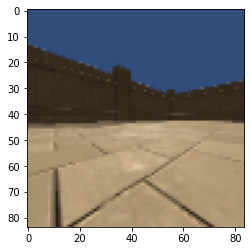

In [115]:
plt.imshow(tensor_reshaped)

In [80]:
f = fixed_x[0].numpy().reshape(84,84,3)
f[0,0]


array([0.19215687, 0.19215687, 0.19215687], dtype=float32)

In [ ]:
def kld(m,s):
    return - np.log(s) + 0.5*(s**2 + m**2 -1)